In [1]:
import matplotlib.pyplot as plt
import plotly.express as px
from tqdm import tqdm
import pandas as pd
import shutil
import time
import csv
import os

## txt_to_csv
Funzione che prende in input:
* il path di un file di origine senza estensione
* il path di un file di destinazione senza estensione
* il l'estensione del file da caricare

In [2]:
def txt_to_csv(filename, filedest, tab_type):
    
    # controllo se nel path di destinazione c'è già il corrispettivo .csv, se c'è lo elimino
    if os.path.isfile(filedest + '.csv'):
        os.remove(filedest + '.csv')
    
    
    file1 = open(filename + tab_type, "rb")
    file_csv = open(filedest + tab_type + '.csv', 'w+', newline ='')

    flag_data = 0

    with file_csv:
        for line in file1:

            if b'\xb0C' in line:     # se trovo il carattere °C lo ignoro
                pass
            else:
                line = line.decode() # altrimenti decodifico la riga

                # cerco la riga con i nomi della tabella
                if line.startswith('NR'):
                    flag_data = 1                  # quando trovo i nomi delle colonne imposto flag_data = 1
                    table_names = line.split()     # divido i nomi delle colonne      
                    table_names.remove('LastLine') # elimino 'LastLine' che fa riferimento ad un singolo dato duplicato
                    #for item in table_names: print(item)
                    write = csv.writer(file_csv)  
                    write.writerow(table_names)
                    #print(table_names)

                # Se sono arrivato alla tabella ma la riga inizia con 0 la salto
                elif flag_data == 1 and line.startswith('0'):
                    pass

                # Se sono arrivato alla tabella (flag_data == 1) e non sono alla prima riga
                # inizio a salvare i dati
                elif flag_data == 1:
                    row = line.split()

                    if not line.startswith('[END]') and len(row) == len(table_names)+1: # le righe con meno di 25 elementi hanno dati mancanti
                        row[-2] = str(row[-2]) + ' ' + str(row[-1]) # unisco l'ora col giorno
                        del row[-1] # elimino la colonna con i giorni
                        write = csv.writer(file_csv)
                        write.writerow(row)

### Coversione da .txt/.tab a Dataframe
* creo un DataFrame vuoto
* quando raggiungo la riga dei nomi delle colonne riporto gli stessi nomi per le colonne del DataFrame
* aggiungo ogni riga trovata al dataframe

In [69]:
#--- FUNZIONE PER CONVERTIRE UNA TABELLA IN DATAFRAME

def tab_to_df(filename):
        
    file1 = open(filename, "rb")
    df = pd.DataFrame()
    flag_data = 0
    
    pbar = tqdm(file1, desc=filename)
    for line in pbar:

        if b'\xb0C' in line:     # se trovo il carattere °C lo ignoro
            pass
        else:
            line = line.decode() # altrimenti decodifico la riga

            # cerco la riga con i nomi della tabella
            if line.startswith('NR'):
                flag_data = 1                  # quando trovo i nomi delle colonne imposto flag_data = 1
                table_names = line.split()     # divido i nomi delle colonne      
                table_names.remove('LastLine') # elimino 'LastLine' che fa riferimento ad un singolo dato duplicato
                
                # definisco i nomi delle colonne del dataframe
                df = df.reindex(columns = table_names)

            # Se sono arrivato alla tabella ma la riga inizia con 0 la salto
            elif flag_data == 1 and line.startswith('0'):
                pass

            # Se sono arrivato alla tabella (flag_data == 1) e non sono alla prima riga
            # inizio a salvare i dati
            elif flag_data == 1:
                row = line.split()

                if not line.startswith('[END]') and len(row) == len(table_names)+1: # le righe con meno di 25 elementi hanno dati mancanti
                    row[-2] = str(row[-2]) + ' ' + str(row[-1]) # unisco l'ora col giorno
                    del row[-1] # elimino la colonna con i giorni
                    
                    df_length = len(df)
                    df.loc[df_length] = row
    
    #df['DataTime'] = pd.to_datetime(df['DataTime'], format='%H:%M:%S %d.%m.%y', errors='coerce')
    df.set_index('DataTime', drop = True, inplace=True)
    df.index = pd.to_datetime(df.index, format='%H:%M:%S %d.%m.%Y')
    df.drop('NR', axis=1, inplace=True)
    
    for column in df.keys():
        if 'PLC_Byt' in column or column == 'OpMode':
            df.drop(column, axis=1, inplace=True)
        else:
            df[column] = df[column].apply(pd.to_numeric)
    return df
                        
#--- MAIN

#data = tab_to_df('table_new/Diag_temp.tab')
#data.head(50)

In [4]:
def load_data(file):
    #column_subset = ['t_Mach',   't_HydrTa', 't_TTlubr', 't_TT_ab1', 
                     #'t_TT_ab2', 't_HdStUp', 't_HdStLw', 't_Sfrnt1', 
                     #'t_Sfrnt2', 't_Srear',  't_Smotor', 'DataTime']

    df = pd.read_csv (file,
                      #usecols=column_subset,
                      index_col=False)

    df['DataTime'] = pd.to_datetime(df['DataTime'], format='%H:%M:%S %d.%m.%Y')
    
    df.set_index('DataTime', drop = True, inplace=True)
    
    if not df.index.is_monotonic:
        df.sort_index(inplace = True)
    
    df.drop('NR', axis=1, inplace=True)
    
    return df

In [74]:
path = 'table_new2/'
dataDict = {}

for filename in os.listdir(path):
    if (filename.endswith('.txt') or filename.endswith('.tab')): 
        df = tab_to_df(path + filename)
        if len(df) > 1:
            dataDict[filename] = df

for i in dataDict:
    print(i)
#data_all = pd.concat(df_list)
#data_all.sort_index(inplace = True)
#data_all.to_csv(path_dest + tab_name[tab] + '_all.csv')

#columns = list(data_all.columns)
#columns.remove('OpMode')
#data_all[columns] = data_all[columns].apply(pd.to_numeric)
#data_all.info()


table_new2/Diag_temp4.txt: 202it [00:00, 14946.62it/s]
table_new2/Long_term_temp3.txt: 217it [00:00, 8475.24it/s]
table_new2/Long_term_temp.tab: 1446it [00:07, 192.56it/s]
table_new2/Diag_temp3.txt: 202it [00:00, 31981.33it/s]
table_new2/DomoClima_temp.tab: 1437it [00:06, 222.72it/s]
table_new2/DomoClima_temp2.txt: 158it [00:00, 27262.63it/s]
table_new2/Diag_temp.tab: 14600it [02:46, 87.45it/s]
table_new2/Long_term_temp4.txt: 217it [00:00, 9598.86it/s]
table_new2/Long_term_temp.txt: 217it [00:00, 14084.86it/s]
table_new2/DomoClima_temp3.txt: 158it [00:00, 17877.47it/s]
table_new2/Diag_temp2.txt: 202it [00:00, 6303.19it/s]
table_new2/Long_term_temp2.txt: 217it [00:00, 9933.25it/s]
table_new2/DiagnosisProfibus.tab: 25878it [02:17, 188.27it/s]
table_new2/Diag_temp.txt: 14600it [02:41, 90.24it/s]
table_new2/DiagnosisM398.tab: 968it [00:00, 3887.45it/s]
table_new2/DomoClima_temp4.txt: 158it [00:00, 26606.98it/s]
table_new2/hour_air_consumption.tab: 14449it [00:31, 451.78it/s]
table_new2/Dom

Long_term_temp3.txt
Long_term_temp.tab
DomoClima_temp.tab
Diag_temp.tab
Long_term_temp4.txt
Long_term_temp.txt
Long_term_temp2.txt
DiagnosisProfibus.tab
Diag_temp.txt
DiagnosisM398.tab
hour_air_consumption.tab


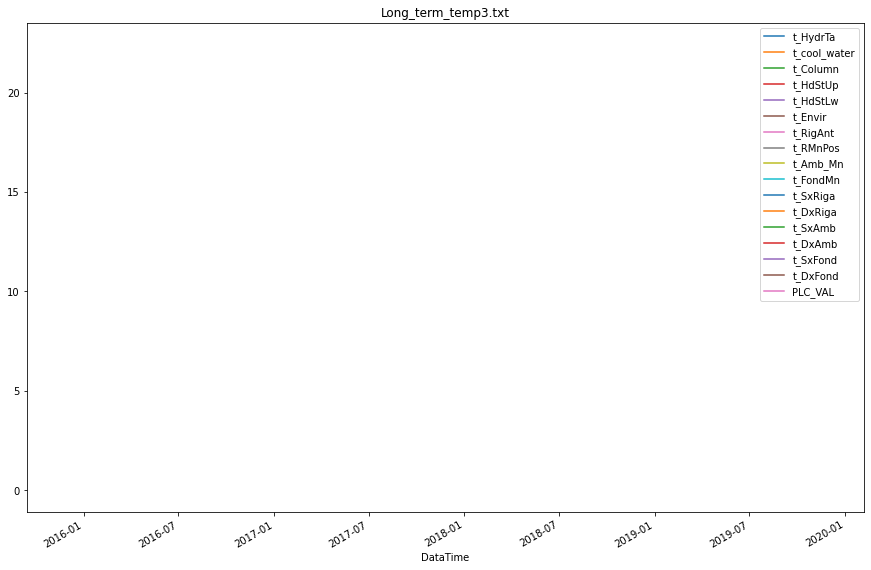

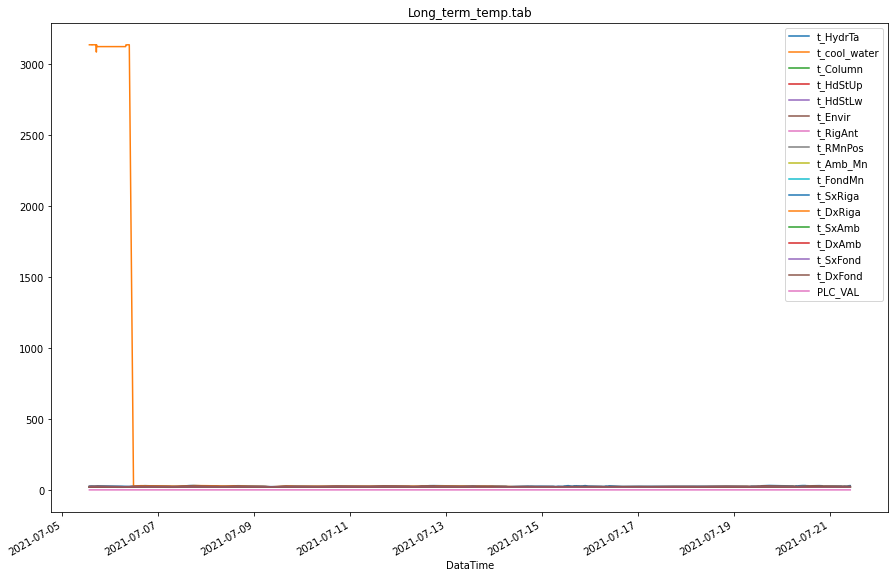

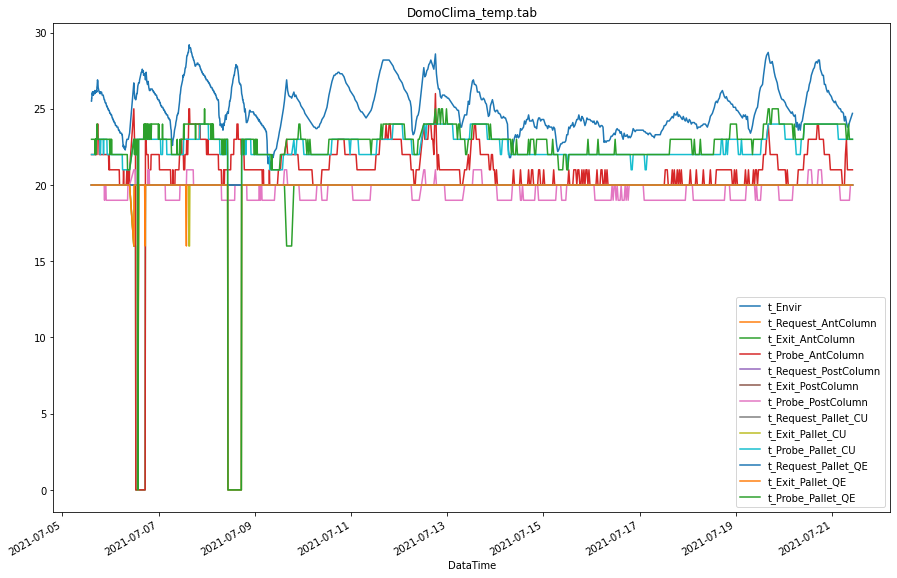

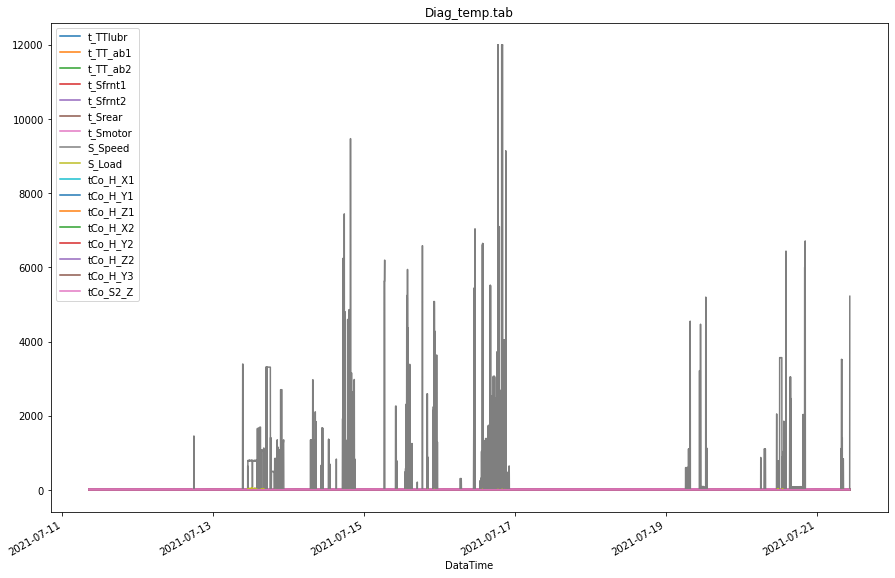

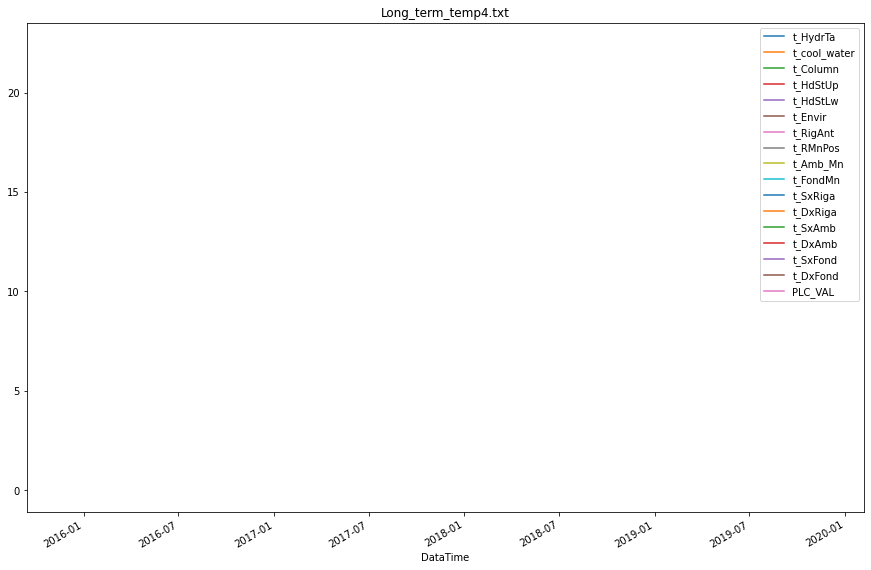

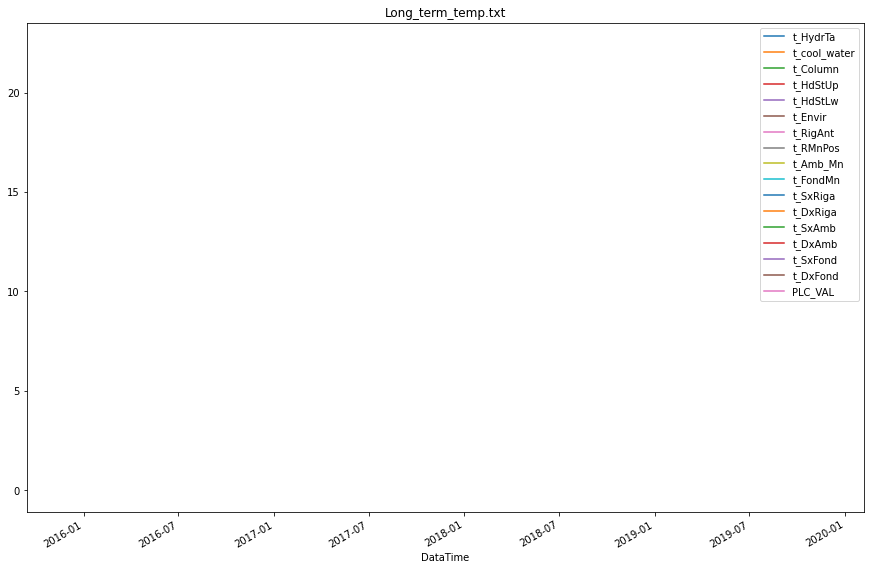

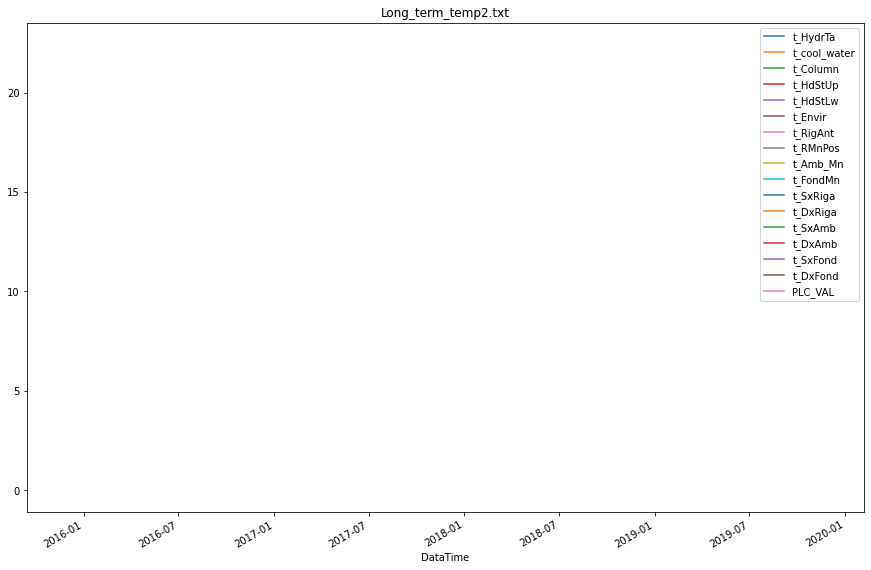

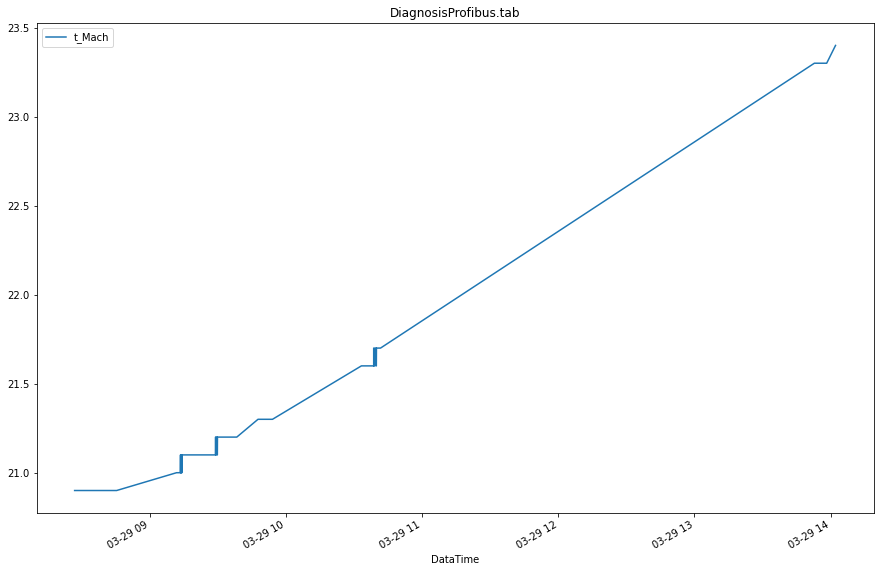

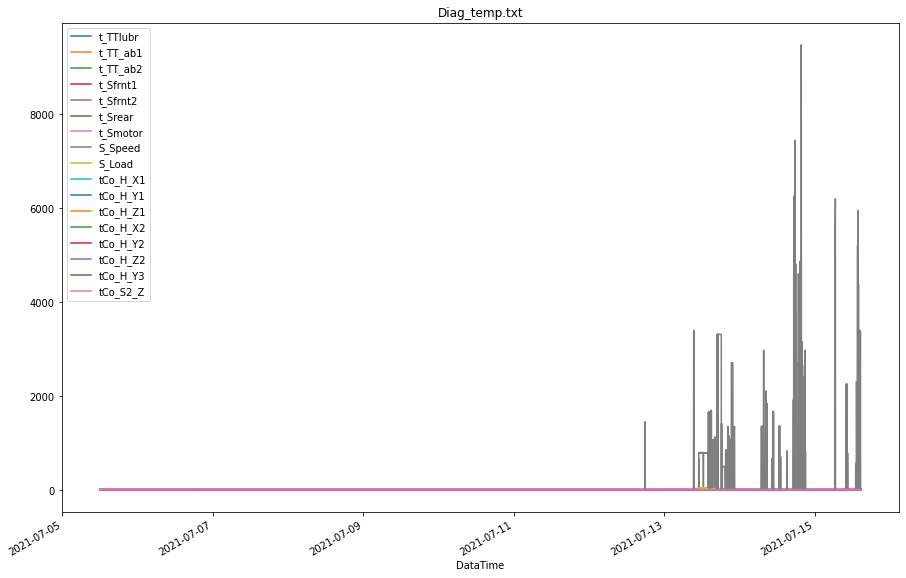

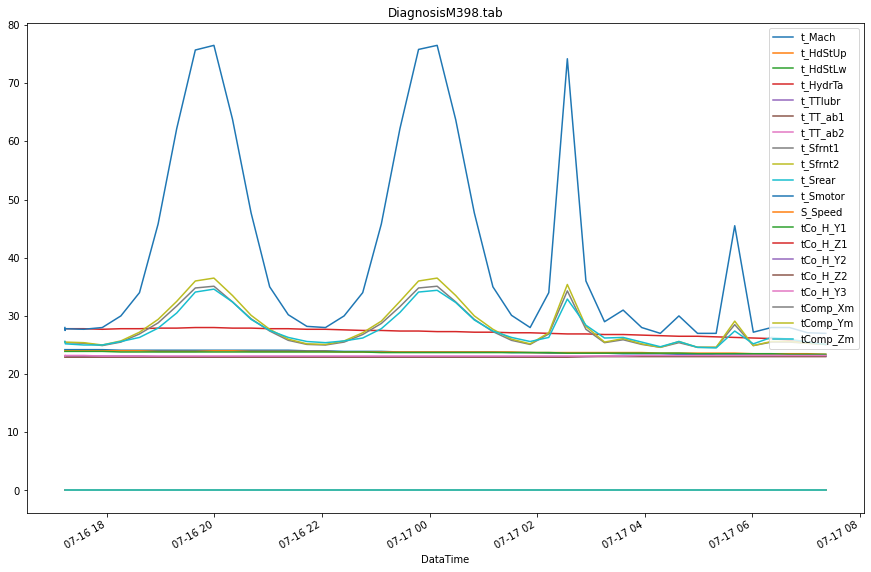

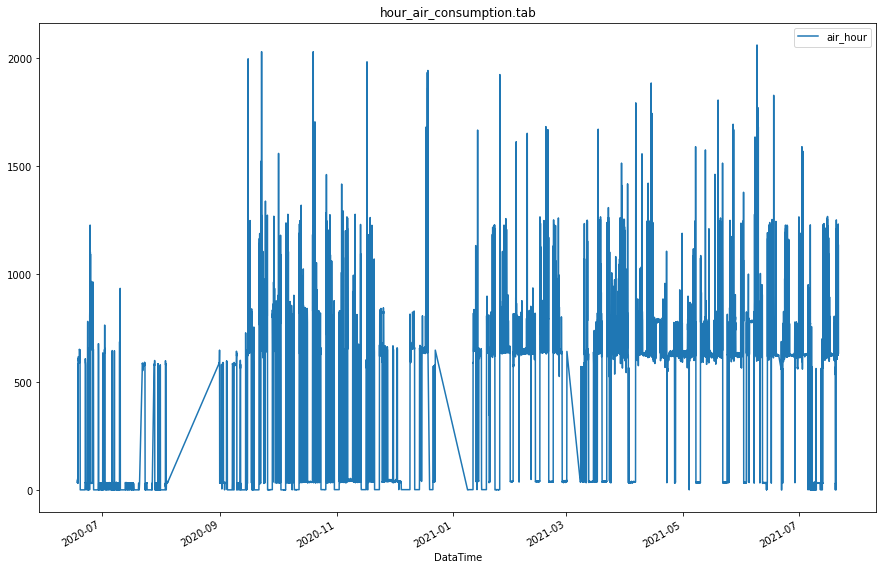

In [75]:
#for column in dataDict['Diag_temp.tab'].keys():
#    if column != 'OpMode':
#        dataDict['Diag_temp.tab'][column] = dataDict['Diag_temp.tab'][column].apply(pd.to_numeric)

#dataDict['Diag_temp.tab'].info()

for tab in dataDict:
    dataDict[tab].plot(figsize=(15,10), title=tab)

In [66]:
#dataDict['Diag_temp.tab'].info()
dataDict['Diag_temp.tab'].drop('OpMode', axis=1, inplace=True)

fig = px.line(dataDict['Diag_temp.tab'], height=800)
fig.show()

In [ ]:
#--- TABLE NEW

tabname = 'Diag_temp'
path = 'table_new/csv/'
dflist=[]
for file in os.listdir(path):
    if file.endswith('.csv') and tabname in file and  not '_all' in file:
        print(file)
        df = load_data(path + file)
        dflist.append(df)
        
data_all = pd.concat(dflist)
data_all.sort_index(inplace = True)
data_all.to_csv(path + tabname + '_all.csv')

In [ ]:
df = pd.read_csv('TOTALE_SONDE.csv', ';')
df.set_index('DataTime', drop = True, inplace=True)
df.sort_index(inplace = True)

        
df.info()
#df.drop('OP', axis=1, inplace=True)
#fig = px.line(df)
#fig.show()

In [ ]:
import plotly.graph_objects as go
df = pd.read_csv ('TOTALE_SONDE.csv', sep=';')
df['DataTime'] = pd.to_datetime(df['DataTime'], format='%d.%m.%Y %H:%M:%S')
df.set_index('DataTime', drop = True, inplace=True)
df = df.resample('5T').mean()
fig = go.Figure()
#for column in df.keys():

visible_value = ['t_Envir', 't_Sfrnt1', 't_Sfrnt2']

for column in df.keys():
    if column in visible_value:
        visible = None
        legendgroup= 'Mario'
    else:
        visible = 'legendonly'
        legendgroup="Elettromandrino"
    fig.add_trace(go.Scatter(
                        x=df.index.tolist(), 
                        y=df[column],
                        mode='lines',
                        name=column,
                        visible=visible,
                        legendgroup=legendgroup,
                        legendgrouptitle_text = "First Group Title"
                            )
                 )
fig.show()


In [ ]:
for (columnName, columnData) in df.iteritems():
    print('Colunm Name : ', columnName)
    #print('Column Contents : ', columnData.values)